# LSTM Example
This notebook will go through an example of processing SMS text messages and determining if they are spam or not spam.  

We will do quite a bit of pre-processing, which I will briefly cover.  Further information in this topic can be found in subsequent courses or in the associated reference links.  

The main purpose of this notebook is to show how to use LSTMs on a deep neural network with text data.

### Dataset
The dataset can be found on this website: https://archive.ics.uci.edu/dataset/228/sms+spam+collection.  It consists of 425 spam messages and 3375 non-spam ("ham") messages.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Workshop Functions
import sys
sys.path.append('..')
from WKDSS320_functions import * 

np.random.seed(1)

In [5]:
df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label','message'])

In [8]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
df.loc[:,'length']=df.loc[:,'message'].apply(len)

In [17]:
# Clean data
from nltk.corpus import stopwords
from nltk import download
import string


In [18]:
download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hiren\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [19]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [25]:
df['message'] = df['message'].apply(text_process)

In [26]:
#write cleaned data back to a file
df.to_csv('SMSSpamCollection_clean.csv')

In [44]:
df[df['length']>905].iloc[0]

label                                                    ham
message    [love, start, attractioni, feel, need, every, ...
length                                                   910
Name: 1085, dtype: object

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


### Trying to use Tokenizer from: 
https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47

and 

https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91


In [73]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers

max_words = 12000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['message'])
sequences = tokenizer.texts_to_sequences(df['message'])
texts = pad_sequences(sequences, maxlen=max_len)
texts.shape

(5572, 100)

In [159]:
np.sum(texts[:,25]>0)

1

In [80]:
mapping = {'ham':0, 'spam':1}
df.loc[:,'label'] = df.loc[:,'label'].map(mapping)

In [99]:
df.loc[4,'label']

0

In [130]:
from keras.utils import to_categorical
labels = to_categorical(df.loc[:,'label'].values, dtype ="uint8")

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3, random_state=1)

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, df.loc[:,'label'].values, test_size=0.3, random_state=1)

In [143]:
y_train.shape

(3900,)

In [144]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [155]:
model = Sequential()
model.add(layers.Embedding(max_words, 5)) #The embedding layer
model.add(layers.LSTM(5,dropout=0.5)) #Our LSTM layer
model.add(layers.Dense(1,activation='sigmoid'))

In [156]:
model.compile(optimizer='adam',loss='binary_crossentropy') 

#checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#history = model1.fit(X_train, y_train.ravel(), epochs=70,validation_data=(X_test, y_test.ravel()),callbacks=[checkpoint1])
model.fit(x = X_train, y = y_train, epochs=25,validation_data=(X_test, y_test))

Epoch 1/25
122/122 [==============================] - 6s 35ms/step - loss: 0.4996 - val_loss: 0.3896
Epoch 2/25
122/122 [==============================] - 4s 32ms/step - loss: 0.3327 - val_loss: 0.2388
Epoch 3/25
122/122 [==============================] - 4s 31ms/step - loss: 0.1659 - val_loss: 0.1418
Epoch 4/25
122/122 [==============================] - 4s 32ms/step - loss: 0.1079 - val_loss: 0.1047
Epoch 5/25
122/122 [==============================] - 4s 32ms/step - loss: 0.0814 - val_loss: 0.0889
Epoch 6/25
122/122 [==============================] - 4s 32ms/step - loss: 0.0623 - val_loss: 0.0741
Epoch 7/25
122/122 [==============================] - 4s 32ms/step - loss: 0.0476 - val_loss: 0.0663
Epoch 8/25
122/122 [==============================] - 4s 32ms/step - loss: 0.0395 - val_loss: 0.0623
Epoch 9/25
122/122 [==============================] - 4s 33ms/step - loss: 0.0299 - val_loss: 0.0594
Epoch 10/25
122/122 [==============================] - 4s 32ms/step - loss: 0.0241 - val_lo

<AxesSubplot:>

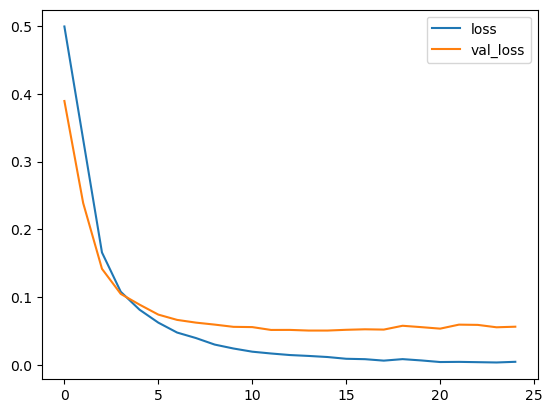

In [157]:
losses = pd.DataFrame(model.history.history)
losses.plot()

#### Test for keras

In [3]:
import tensorflow as tf
text_dataset = tf.data.Dataset.from_tensor_slices(["foo", "bar", "baz"])

In [7]:
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=5000,
 output_mode='int',
 output_sequence_length=4)